This document covers model training.

#Install and import libraries

In [ ]:
!pip install -U xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install probscale

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import shap
from xgboost import plot_tree
import probscale
import seaborn as sns
from xgboost import plot_importance

Installation of MLFlow in Google Colab (Code from: https://stackoverflow.com/questions/61615818/setting-up-mlflow-on-google-colab )

In [ ]:
!pip install mlflow
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import mlflow

if mlflow.active_run is not None:
  mlflow.end_run()

from pyngrok import ngrok

from mlflow.models.signature import infer_signature

#Read data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
work_folder = '/content/drive/MyDrive/nyc_taxis/'

We will train the model with a reduced sample of the full dataset, as training with all of the data would require a considerable amount of training time and computational power. As we saw in the last notebook, the distribution of the input and target variables of the sample that we were working with is extremely similar to that of the full one.

If we wanted to train with the full dataset, we could choose pyspark.ml.regression.GBTRegressor, XGBoost4J-Spark or use scikit-learn with PySpark Pandas UDFs

In [ ]:
nyc_yellow_tripdata_df = pd.read_csv(work_folder+"yellow_tripdata_clean_sample.csv",sep='|')

In [ ]:
nyc_yellow_tripdata_df.shape

(989833, 26)

In [ ]:
nyc_yellow_tripdata_df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,fare_amount,extra,mta_tax,...,payment_type,VendorID,tpep_pickup_datetime_dayofweek,tpep_dropoff_datetime_dayofweek,tpep_pickup_datetime_hour,tpep_dropoff_datetime_hour,PULocation_centroid_x,PULocation_centroid_y,DOLocation_centroid_x,DOLocation_centroid_y
0,2017-03-02 15:59:03,2017-03-02 16:33:04,1.0,16.60,0,68,1,NaN,0.0,0.5,...,Credit card,Creative Mobile Technologies,3,3,15,16,-73.999918,40.748427,-74.174002,40.691830
1,2017-03-24 14:35:50,2017-03-24 15:18:55,2.0,12.80,0,231,1,NaN,0.0,0.5,...,Credit card,Creative Mobile Technologies,4,4,14,15,-74.007880,40.717773,-74.174002,40.691830
2,2017-03-02 21:42:07,2017-03-02 22:07:56,2.0,3.35,0,230,4,18.0,0.5,0.5,...,Credit card,VeriFone Inc,3,3,21,22,-73.984197,40.759818,-73.976968,40.723752
3,2017-03-16 20:22:44,2017-03-16 20:26:59,1.0,0.70,0,79,4,5.0,0.5,0.5,...,Credit card,Creative Mobile Technologies,3,3,20,20,-73.985937,40.727620,-73.976968,40.723752
4,2017-03-18 01:14:03,2017-03-18 01:25:33,1.0,1.96,0,137,4,9.0,0.5,0.5,...,Credit card,VeriFone Inc,5,5,1,1,-73.976495,40.740439,-73.976968,40.723752


In [ ]:
nyc_yellow_tripdata_df.describe()

,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,fare_amount,extra,mta_tax,tip_amount,tolls_amount,...,total_amount,meter_engagement_time_minutes,tpep_pickup_datetime_dayofweek,tpep_dropoff_datetime_dayofweek,tpep_pickup_datetime_hour,tpep_dropoff_datetime_hour,PULocation_centroid_x,PULocation_centroid_y,DOLocation_centroid_x,DOLocation_centroid_y
count,988162.000000,970966.000000,989833.000000,989833.000000,989833.000000,979384.000000,985852.000000,989833.0,989833.000000,986377.000000,...,977795.000000,974690.000000,989833.000000,989833.000000,989833.000000,989833.000000,973846.000000,973846.000000,974647.000000,974647.000000
mean,1.608855,2.886404,0.003962,163.655345,161.458036,13.108121,0.322723,0.5,2.727307,0.321268,...,16.978683,14.717158,2.994409,2.998880,13.780027,13.792334,-73.973445,40.751444,-73.974455,40.751948
std,1.255089,3.264552,0.062822,66.151759,70.227671,10.067891,0.371520,0.0,2.475968,1.314394,...,12.462045,10.737749,1.877437,1.879844,6.307148,6.401941,0.037977,0.027686,0.033572,0.031144
min,1.000000,0.300000,0.000000,1.000000,1.000000,3.500000,0.000000,0.5,0.000000,0.000000,...,4.550000,1.270000,0.000000,0.000000,0.000000,0.000000,-74.174002,40.551862,-74.233535,40.525491
25%,1.000000,1.020000,0.000000,114.000000,112.000000,7.000000,0.000000,0.5,1.350000,0.000000,...,9.360000,7.130000,1.000000,1.000000,9.000000,9.000000,-73.992438,40.736824,-73.990896,40.735035
50%,1.000000,1.700000,0.000000,162.000000,162.000000,10.000000,0.000000,0.5,2.000000,0.000000,...,12.950000,11.730000,3.000000,3.000000,14.000000,15.000000,-73.981532,40.756688,-73.978632,40.756688
75%,2.000000,3.120000,0.000000,233.000000,234.000000,15.000000,0.500000,0.5,3.060000,0.000000,...,18.960000,19.020000,5.000000,5.000000,19.000000,19.000000,-73.965635,40.768615,-73.965146,40.768615
max,9.000000,18.970000,1.000000,265.000000,265.000000,52.000000,1.000000,0.5,21.860000,5.760000,...,70.270000,64.720000,6.000000,6.000000,23.000000,23.000000,-73.711025,40.899528,-73.711025,40.899528


#One-hot-encoding

First, we use one-hot encoding for the categorical variables

In [ ]:
one_hot_encoded_columns = pd.get_dummies(nyc_yellow_tripdata_df[['RatecodeID','payment_type','VendorID']])
one_hot_encoded_columns

,RatecodeID_Group ride,RatecodeID_JFK,RatecodeID_Nassau or Westchester,RatecodeID_Negotiated fare,RatecodeID_Newark,RatecodeID_Standard rate,payment_type_Credit card,VendorID_Creative Mobile Technologies,VendorID_VeriFone Inc
0,0,0,0,0,1,0,1,1,0
1,0,0,0,0,1,0,1,1,0
2,0,0,0,0,0,1,1,0,1
3,0,0,0,0,0,1,1,1,0
4,0,0,0,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...
989828,0,0,0,0,0,1,1,0,1
989829,0,0,0,0,0,1,1,0,1
989830,0,0,0,1,0,0,1,1,0
989831,0,0,0,0,0,1,1,1,0


After having the one-hot-encoded versions of these variables, we can drop the original ones

In [ ]:
nyc_yellow_tripdata_df = pd.concat([nyc_yellow_tripdata_df,one_hot_encoded_columns],axis=1)
nyc_yellow_tripdata_df = nyc_yellow_tripdata_df.drop(columns=['RatecodeID','payment_type','VendorID'])

We can also drop the variables PULocationID and DOLocationID, because they are categorical. We already have the location information through the coordinates of the centroids of the pick-up and drop-off location: PULocation_centroid_x, PULocation_centroid_y, DOLocation_centroid_x, DOLocation_centroid_y

In [ ]:
nyc_yellow_tripdata_df = nyc_yellow_tripdata_df.drop(columns=['PULocationID', 'DOLocationID'])

#Variable selection

In the previous notebook, when we performed a bivariate analysis with the target variable, we could see that the variables that seemed to have a considerable influence on the tip amount were: trip_distance, fare_amount, tolls_amount, total_amount, meter_engagement_time_minutes and RatecodeID. 

Also, the tip amount seemed to vary in terms of pick-up and drop-off locations (variables PULocation_centroid_x, PULocation_centroid_y, DOLocation_centroid_x, DOLocation_centroid_y).

In [ ]:
nyc_yellow_tripdata_df.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'store_and_fwd_flag', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'meter_engagement_time_minutes',
       'tpep_pickup_datetime_dayofweek', 'tpep_dropoff_datetime_dayofweek',
       'tpep_pickup_datetime_hour', 'tpep_dropoff_datetime_hour',
       'PULocation_centroid_x', 'PULocation_centroid_y',
       'DOLocation_centroid_x', 'DOLocation_centroid_y',
       'RatecodeID_Group ride', 'RatecodeID_JFK',
       'RatecodeID_Nassau or Westchester', 'RatecodeID_Negotiated fare',
       'RatecodeID_Newark', 'RatecodeID_Standard rate',
       'payment_type_Credit card', 'VendorID_Creative Mobile Technologies',
       'VendorID_VeriFone Inc'],
      dtype='object')

Firstly, we calculate the sum of the following variables: fare_amount, extra, mta_tax, tip_amount, tolls_amount and improvement_surcharge:

In [ ]:
check_df = nyc_yellow_tripdata_df.copy()

check_df['sum_quantities'] = check_df['fare_amount'] + check_df['extra'] + check_df['mta_tax'] + check_df['tip_amount'] + check_df['tolls_amount'] + check_df['improvement_surcharge']
check_df['sum_quantities_equals_total_amount'] = np.round(check_df['sum_quantities'],2) == np.round(check_df['total_amount'],2)
check_df = check_df[['fare_amount','extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','total_amount','sum_quantities','sum_quantities_equals_total_amount']].dropna()

In [ ]:
check_df

,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,sum_quantities,sum_quantities_equals_total_amount
2,18.0,0.5,0.5,3.86,0.0,0.3,23.16,23.16,True
3,5.0,0.5,0.5,0.63,0.0,0.3,6.93,6.93,True
4,9.0,0.5,0.5,1.54,0.0,0.3,11.84,11.84,True
5,10.0,0.5,0.5,2.00,0.0,0.3,13.30,13.30,True
6,5.5,0.5,0.5,1.70,0.0,0.3,8.50,8.50,True
...,...,...,...,...,...,...,...,...,...
989825,4.5,0.0,0.5,1.05,0.0,0.3,6.35,6.35,True
989826,30.0,0.0,0.5,5.00,0.0,0.3,35.80,35.80,True
989827,3.5,0.0,0.5,0.86,0.0,0.3,5.16,5.16,True
989828,19.5,0.0,0.5,4.00,0.0,0.3,24.30,24.30,True


## [! IMPORTANT REMARK]
In the case that we have values for all of them, we can see that the sum of all of them equals total_amount in 99.65% of the cases. Since the sum included the tip amount, this means that we cannot use the variable total_amount to predict the tip amount. We won't have the value of total_amount at prediction time before the passenger gives the tip!

In [ ]:
check_df['sum_quantities_equals_total_amount'].mean()

0.996558474037268

In [ ]:
nyc_yellow_tripdata_df = nyc_yellow_tripdata_df.drop(columns=['total_amount'])

Even if we have a proper idea of variable relationships after the EDA, we still analyze the correlation matrix of the input variables with the target variable to make a final variable selection decision.

We first have a look at Pearson’s correlation coefficient. This coefficient only measures linear relationships, so the fact that it is close to zero does not imply that there isn't any relationship between the two variables: it just implies that there is not a linear relationship

In [ ]:
corr = nyc_yellow_tripdata_df.corr(method='pearson')

Below we show the variables ordered by the highest absolute correlation (we do not mind whether it is a positive or a negative correlation to select a variable as important) with the target variable. 

As expected, we can see that the highest correlated variables are the ones that we had already identified in the EDA: 

* fare_amount
* trip_distance
* meter_engagement_time_minutes
* tolls_amount
* RatecodeID_Standard rate
* RatecodeID_JFK
* PULocation_centroid_x
* DOLocation_centroid_x
* PULocation_centroid_y
* DOLocation_centroid_y
* RatecodeID_Newark

In [ ]:
corr_target = corr[corr.index == 'tip_amount'].abs()
corr_target.transpose().sort_values(by='tip_amount',ascending=False)

,tip_amount
tip_amount,1.000000
fare_amount,0.832701
trip_distance,0.797355
meter_engagement_time_minutes,0.729449
tolls_amount,0.597495
RatecodeID_Standard rate,0.518065
RatecodeID_JFK,0.478611
PULocation_centroid_x,0.453579
DOLocation_centroid_x,0.253916
PULocation_centroid_y,0.223924


In [ ]:
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

this method is deprecated in favour of `Styler.format(precision=..)`
All-NaN slice encountered
All-NaN slice encountered


,passenger_count,trip_distance,store_and_fwd_flag,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,meter_engagement_time_minutes,tpep_pickup_datetime_dayofweek,tpep_dropoff_datetime_dayofweek,tpep_pickup_datetime_hour,tpep_dropoff_datetime_hour,PULocation_centroid_x,PULocation_centroid_y,DOLocation_centroid_x,DOLocation_centroid_y,RatecodeID_Group ride,RatecodeID_JFK,RatecodeID_Nassau or Westchester,RatecodeID_Negotiated fare,RatecodeID_Newark,RatecodeID_Standard rate,payment_type_Credit card,VendorID_Creative Mobile Technologies,VendorID_VeriFone Inc
passenger_count,1.00,0.01,-0.02,0.01,0.00,nan,0.01,0.01,nan,0.01,0.02,0.02,0.01,0.01,0.00,-0.00,0.00,-0.00,-0.00,0.01,0.00,-0.01,0.00,-0.00,nan,-0.28,0.28
trip_distance,0.01,1.00,0.02,0.96,-0.04,nan,0.80,0.63,nan,0.77,0.00,0.00,-0.01,-0.02,0.53,-0.23,0.36,-0.19,-0.00,0.53,0.04,0.05,0.17,-0.55,nan,-0.02,0.02
store_and_fwd_flag,-0.02,0.02,1.00,0.02,-0.00,nan,0.02,0.03,nan,0.02,-0.00,-0.00,0.00,0.00,0.01,-0.01,0.01,-0.01,-0.00,0.02,-0.00,-0.00,-0.00,-0.02,nan,0.07,-0.07
fare_amount,0.01,0.96,0.02,1.00,-0.07,nan,0.83,0.63,nan,0.90,-0.01,-0.01,0.01,0.01,0.53,-0.28,0.40,-0.20,nan,0.60,0.02,0.06,0.02,-0.60,nan,-0.02,0.02
extra,0.00,-0.04,-0.00,-0.07,1.00,nan,-0.04,-0.07,nan,-0.05,-0.15,-0.15,0.37,0.34,-0.07,-0.02,-0.02,-0.01,-0.00,-0.12,0.00,-0.05,-0.02,0.13,nan,-0.00,0.00
mta_tax,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
tip_amount,0.01,0.80,0.02,0.83,-0.04,nan,1.00,0.60,nan,0.73,-0.02,-0.02,0.02,0.02,0.45,-0.22,0.25,-0.19,0.00,0.48,0.06,0.09,0.19,-0.52,nan,-0.02,0.02
tolls_amount,0.01,0.63,0.03,0.63,-0.07,nan,0.60,1.00,nan,0.47,-0.03,-0.03,-0.00,0.00,0.46,-0.09,0.33,-0.05,-0.00,0.46,0.01,0.00,0.00,-0.44,nan,-0.02,0.02
improvement_surcharge,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
meter_engagement_time_minutes,0.01,0.77,0.02,0.90,-0.05,nan,0.73,0.47,nan,1.00,-0.03,-0.03,0.04,0.05,0.37,-0.18,0.21,-0.18,-0.00,0.35,0.03,0.04,0.09,-0.36,nan,-0.01,0.01


We now calculate Spearman’s correlation coefficient. While Pearson’s measures a linear relationship between two variables,  Spearman’s measures a monotonic relationship. While linear relationships mean two variables move together at a constant rate, monotonic relationships measure how likely it is for two variables to move in the same direction, but not necessarily at a constant rate.


In [ ]:
corr = nyc_yellow_tripdata_df.corr(method='spearman')

Although some of them appear in a different order, the highest correlated variables with the tip amount are still the same ones that we had identified before.

In [ ]:
corr_target = corr[corr.index == 'tip_amount'].abs()
corr_target.transpose().sort_values(by='tip_amount',ascending=False)

,tip_amount
tip_amount,1.000000
fare_amount,0.729842
meter_engagement_time_minutes,0.704343
trip_distance,0.676396
tolls_amount,0.340985
RatecodeID_Standard rate,0.226791
RatecodeID_JFK,0.223535
DOLocation_centroid_y,0.098148
PULocation_centroid_y,0.077956
DOLocation_centroid_x,0.073287


In [ ]:
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

this method is deprecated in favour of `Styler.format(precision=..)`
All-NaN slice encountered
All-NaN slice encountered


,passenger_count,trip_distance,store_and_fwd_flag,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,meter_engagement_time_minutes,tpep_pickup_datetime_dayofweek,tpep_dropoff_datetime_dayofweek,tpep_pickup_datetime_hour,tpep_dropoff_datetime_hour,PULocation_centroid_x,PULocation_centroid_y,DOLocation_centroid_x,DOLocation_centroid_y,RatecodeID_Group ride,RatecodeID_JFK,RatecodeID_Nassau or Westchester,RatecodeID_Negotiated fare,RatecodeID_Newark,RatecodeID_Standard rate,payment_type_Credit card,VendorID_Creative Mobile Technologies,VendorID_VeriFone Inc
passenger_count,1.00,0.02,-0.02,0.02,0.02,nan,0.01,0.01,nan,0.01,0.04,0.04,0.03,0.02,-0.01,-0.00,-0.00,-0.00,-0.00,0.01,0.00,-0.01,0.00,-0.01,nan,-0.24,0.24
trip_distance,0.02,1.00,0.01,0.93,0.04,nan,0.68,0.36,nan,0.83,0.02,0.02,0.02,0.02,0.06,-0.07,0.14,-0.09,-0.00,0.21,0.02,0.03,0.07,-0.22,nan,-0.03,0.03
store_and_fwd_flag,-0.02,0.01,1.00,0.02,-0.01,nan,0.01,0.03,nan,0.01,-0.01,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.01,-0.00,0.02,-0.00,-0.00,-0.00,-0.02,nan,0.07,-0.07
fare_amount,0.02,0.93,0.02,1.00,-0.02,nan,0.73,0.38,nan,0.97,-0.01,-0.01,0.02,0.02,0.06,-0.10,0.11,-0.10,nan,0.26,0.02,0.04,0.01,-0.27,nan,-0.01,0.01
extra,0.02,0.04,-0.01,-0.02,1.00,nan,0.03,-0.07,nan,-0.04,-0.13,-0.12,0.46,0.43,-0.08,-0.07,-0.00,-0.04,-0.00,-0.13,0.00,-0.05,-0.02,0.14,nan,-0.00,0.00
mta_tax,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
tip_amount,0.01,0.68,0.01,0.73,0.03,nan,1.00,0.34,nan,0.70,-0.03,-0.03,0.05,0.05,0.06,-0.08,0.07,-0.10,0.00,0.22,0.02,0.02,0.06,-0.23,nan,-0.01,0.01
tolls_amount,0.01,0.36,0.03,0.38,-0.07,nan,0.34,1.00,nan,0.33,-0.03,-0.03,-0.01,-0.00,0.23,0.03,0.15,0.02,-0.00,0.46,0.01,0.00,0.00,-0.43,nan,-0.02,0.02
improvement_surcharge,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
meter_engagement_time_minutes,0.01,0.83,0.01,0.97,-0.04,nan,0.70,0.33,nan,1.00,-0.03,-0.03,0.04,0.04,0.04,-0.09,0.06,-0.12,-0.00,0.21,0.03,0.03,0.07,-0.22,nan,-0.01,0.01


We can also observe from Pearson's result that, apart from being correlated with the tip amount, the variables fare_amount, trip_distance and meter_engagement_time_minutes are highly correlated between them. This makes sense from a logical perspective.

When two or more predictor variables are highly correlated with each other, this is known as multicollinearity. Some machine learning algorithms cannot handle multicollinearity well during training. This won't be a problem in the case of the algorithm that we will select later (XGBoost), but if we were using an algorithm that is affected by multicollinearity (such as a linear regression), we would have to avoid including predictor variables for which multicollinearity occurs.

We select the variables with the highest correlation:

In [ ]:
variables_to_keep = ['tip_amount',
                     'fare_amount','tolls_amount','meter_engagement_time_minutes','trip_distance',
                     'PULocation_centroid_x','PULocation_centroid_y','DOLocation_centroid_x','DOLocation_centroid_y',
                     'RatecodeID_JFK','RatecodeID_Newark', 'RatecodeID_Standard rate']

In [ ]:
nyc_yellow_tripdata_selection_df = nyc_yellow_tripdata_df[variables_to_keep]

In [ ]:
nyc_yellow_tripdata_selection_df.head()

,tip_amount,fare_amount,tolls_amount,meter_engagement_time_minutes,trip_distance,PULocation_centroid_x,PULocation_centroid_y,DOLocation_centroid_x,DOLocation_centroid_y,RatecodeID_JFK,RatecodeID_Newark,RatecodeID_Standard rate
0,12.00,NaN,NaN,34.02,16.60,-73.999918,40.748427,-74.174002,40.691830,0,1,0
1,14.45,NaN,NaN,43.08,12.80,-74.007880,40.717773,-74.174002,40.691830,0,1,0
2,3.86,18.0,0.0,25.82,3.35,-73.984197,40.759818,-73.976968,40.723752,0,0,1
3,0.63,5.0,0.0,4.25,0.70,-73.985937,40.727620,-73.976968,40.723752,0,0,1
4,1.54,9.0,0.0,11.50,1.96,-73.976495,40.740439,-73.976968,40.723752,0,0,1


#Train model

##Choose algorithm

We are going to use a XGBRegressor to train this model. The reasons why we choose this model are:

*   There are missing values in the predictor variables after the cleaning, and XGBoost uses an 'sparsity-aware split finding' method to learn how to best split the missing values in the tree.
*   The data size is large enough to benefit from training with XGBoost (which is a highly optimized algorithm capable of running parallel threads).
*   Tree-based algorithms are not as affected by outliers as other algorithms.
*   Tree-based algorithms are not as affected by multicollinearity in the predictor variables as other algorithms.
*   Tree-based algorithms combine well with popular XAI methods (e.g., SHAP).
*   Ensemble algorithms generally achieve high performance.


Because of time restrictions, I will not be trying out other algorithms, but we could try out other popular algorithms as well like random forest or LightGBM. 

## Train-test split

We first split the data into train / test, with sizes of 80% and 20% respectively

In [ ]:
X = nyc_yellow_tripdata_selection_df.copy().drop(columns=['tip_amount'])
y = nyc_yellow_tripdata_selection_df.copy()['tip_amount']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
train_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
test_dmatrix = xgb.DMatrix(data=X_test,label=y_test)

## Hyperparameter tuning

To start with, we set values for the most important parameters of XGBoost.

The documentation for all available parameters can be found at:
https://xgboost.readthedocs.io/en/stable/parameter.html

Here are the key parameters that we will set:


*   learning_rate [default=0.3]: step size shrinkage used to prevent overfitting. 
*   max_depth [default=6]: maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
*   min_child_weight [default=1]: minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. 
*   subsample [default=1]: subsample ratio of the training instances prior to growing trees. Subsampling will occur once in every boosting iteration.
*   colsample_bytree [default=1]: the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
*   reg_alpha [default=0]: L1 regularization term on weights. Increasing this value will make the model more conservative.
*   reg_lambda [default=1]: L2 regularization term on weights. Increasing this value will make the model more conservative.
*   gamma  [default=0]: minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.

Our choices different from default values are:
*   learning_rate: we decrease it, since it will prevent overfitting, although this will also increase the number of trees needed and result in longer training times.
*   max_depth: after a few trials, I obtained better results by increasing this value, so I start with a higher value than the default one.
*   subsample: I set a ratio of 50% to help avoid overfitting.
*   colsample_bytree: I set a ratio of 80% to help avoid overfitting.
*   reg_alpha: I set a value of 0.5 to help avoid overfitting.
*   reg_lambda: I set a value of 1.5 to help avoid overfitting.

Another important thing is the objective that is chosen to train the algorithm. In this case, the target variable is Tweedie-distributed, so we choose the objective "reg:tweedie":

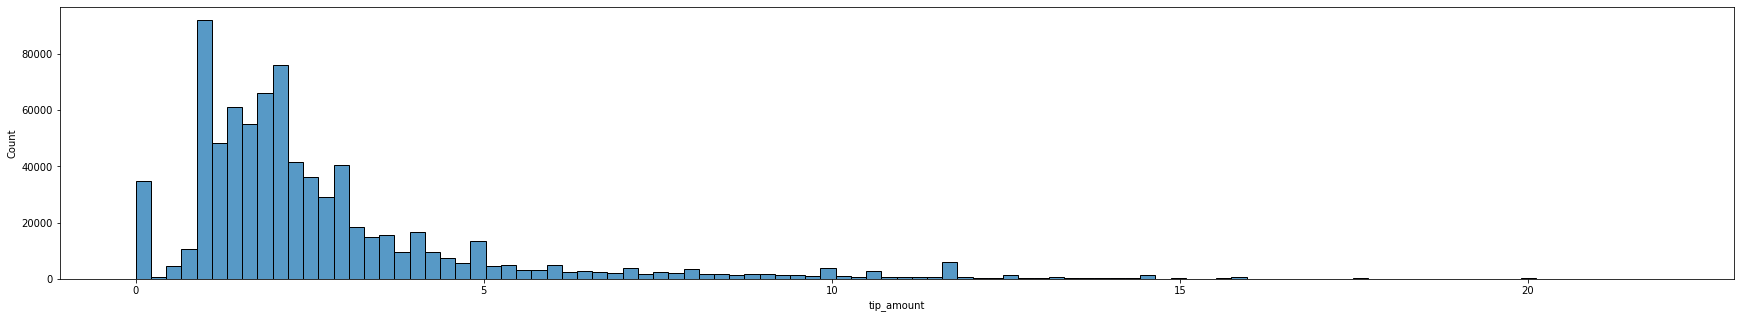

In [ ]:
fig,axs = plt.subplots(1,1, figsize=(30,5))
sns.histplot(y_train, bins = 100)

We also set a random_state to be able to reproduce results.

For regression problems, RMSE (root mean square error) is one of the most common evaluation metrics, so we choose this one to evaluate our results. We also select RMSLE (root mean square log error), because it reduces errors generated by outliers in the dataset and the target variable has no values that are less than -1 (which is a problem when using a log error). Moreover, we also select MAE (mean absolute error), because it is the easiest to understand. The MAPE (mean absolute percentage error) does not make sense in this case, because a big part of the target values are zero, and MAPE would have an "infinity" result in those cases.

In [ ]:
learning_rate = 0.05 #[default=0.3]
max_depth = 12 #[default=6]
min_child_weight = 1 #[default=1]
subsample =0.5 #subsample [default=1]
colsample_bytree = 0.8 #[default=1]
reg_alpha =0.5 #[default=0]
reg_lambda =1.5 #[default=1]
gamma=0 #[default=0]

objective = "reg:tweedie"

random_state=0

params = {
        "objective": objective, 
        "learning_rate":learning_rate,

        "max_depth":max_depth,
        "min_child_weight":min_child_weight,

        "subsample":subsample,
        "colsample_bytree": colsample_bytree,
        
        "reg_alpha":reg_alpha,
        "reg_lambda":reg_lambda,
        "gamma":gamma,
        
        "random_state":random_state,
        "eval_metric":['rmse', 'rmsle', 'mae']
   }

### N_estimators

After having fixed a learning rate, the next important variable to fix is the number of estimators (boosting rounds). The more estimators that we use, the more likely that the model will overfit, so we should stop adding estimators when we see that the evaluation metrics are no longer improving.

Therefore, we set a large number of boosting rounds to start with, and we will then have a look at different evaluation metrics (RMSE, RMSLE and MAE)

In [ ]:
num_boost_round=300

In [ ]:
evals_result = {}
xgb_reg = xgb.train(params = params,
          dtrain = train_dmatrix,
          verbose_eval=1,
          num_boost_round = num_boost_round,
          evals =  [(train_dmatrix, 'train'),(test_dmatrix, 'test')],
          evals_result=evals_result
          )

2022/06/26 18:34:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3a3bdf1d8c8e484e9ba0fa5927fdc44b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	train-rmse:3.30925	train-rmsle:0.90213	train-mae:2.24527	test-rmse:3.28924	test-rmsle:0.89930	test-mae:2.23245
[1]	train-rmse:3.28288	train-rmsle:0.88267	train-mae:2.21563	test-rmse:3.26292	test-rmsle:0.87990	test-mae:2.20290
[2]	train-rmse:3.25526	train-rmsle:0.86296	train-mae:2.18502	test-rmse:3.23538	test-rmsle:0.86025	test-mae:2.17239
[3]	train-rmse:3.22634	train-rmsle:0.84304	train-mae:2.15349	test-rmse:3.20653	test-rmsle:0.84041	test-mae:2.14097
[4]	train-rmse:3.19617	train-rmsle:0.82299	train-mae:2.12108	test-rmse:3.17646	test-rmsle:0.82044	test-mae:2.10869
[5]	train-rmse:3.16470	train-rmsle:0.80286	train-mae:2.08784	test-rmse:3.14509	test-rmsle:0.80039	test-mae:2.07558
[6]	train-rmse:3.13199	train-rmsle:0.78271	train-mae:2.05383	test-rmse:3.11250	test-rmsle:0.78033	test-mae:2.04171
[7]	train-rmse:3.09808	train-rmsle:0.76262	train-mae:2.01912	test-rmse:3.07874	test-rmsle:0.76035	test-mae:2.00718
[8]	train-rmse:3.06290	train-rmsle:0.74264	train-mae:1.98385	test-rmse:3.04373	t

2022/06/26 18:44:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.7/dist-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


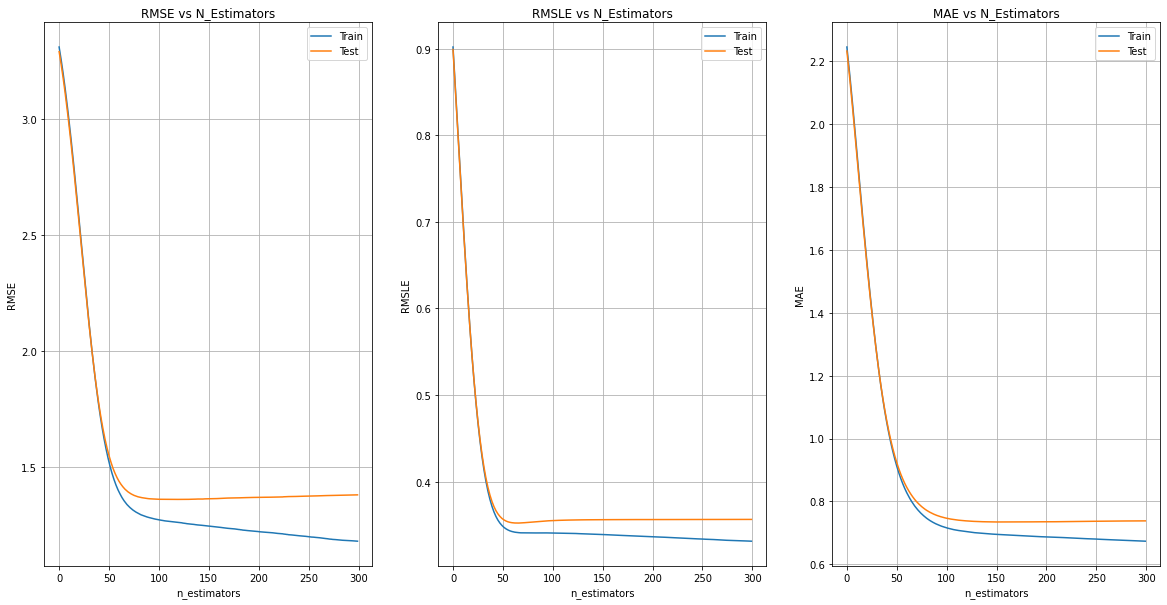

In [ ]:
################## Plot ########################

results = evals_result

fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.plot(results['train']['rmse'],label='Train')
plt.plot(results['test']['rmse'],label='Test')
plt.title('RMSE vs N_Estimators')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(results['train']['rmsle'],label='Train')
plt.plot(results['test']['rmsle'],label='Test')
plt.title('RMSLE vs N_Estimators')
plt.xlabel('n_estimators')
plt.ylabel('RMSLE')
plt.legend()
plt.grid(True)

plt.subplot(1,3,3)
plt.plot(results['train']['mae'],label='Train')
plt.plot(results['test']['mae'],label='Test')
plt.title('MAE vs N_Estimators')
plt.xlabel('n_estimators')
plt.ylabel('MAE');
plt.legend()
plt.grid(True)

We can observe that none of the evaluation metrics are improving after the number of estimators is larger than ~90, so we set this value for the number of estimators:

In [ ]:
num_boost_round = 90

### Grid search with cross-validation for other key parameters

We can optimize the values of the other parameters of the model by using a cross-validated grid-search over a parameter grid. The grid-search algorithm tries all possible combinations of the specified input parameter values and returns the combination with the best performance (in this case, we select the MAE metric to measure performance, since it is a good indicator to measure the model error for regression tasks).

Ideally, we would want to try different values for all parameters, but because of time constraints, I will just use a grid-search with 4 different parameter combinations, just to demonstrate how this method works.

In [ ]:
gridsearch_params = [
    (max_depth, subsample)
    for max_depth in [12,13]
    for subsample in [0.5,0.6]
]

In [ ]:
gridsearch_params

[(12, 0.5), (12, 0.6), (13, 0.5), (13, 0.6)]

In [ ]:
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None

for max_depth, subsample in gridsearch_params:
    print("CV with max_depth={}, subsample={}".format(
                             max_depth,
                             subsample))
    
    # Update our parameters
    params['max_depth'] = max_depth
    params['subsample'] = subsample
    # Run CV
    cv_results = xgb.cv(
        params = params,
        dtrain = train_dmatrix,
        num_boost_round=num_boost_round,
        nfold=5,
        verbose_eval=1,
        metrics={'mae'},
    )

    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,subsample)

CV with max_depth=12, subsample=0.5
[0]	train-mae:2.24527+0.00170	test-mae:2.24529+0.00680
[1]	train-mae:2.21565+0.00167	test-mae:2.21569+0.00674
[2]	train-mae:2.18503+0.00166	test-mae:2.18509+0.00667
[3]	train-mae:2.15348+0.00163	test-mae:2.15357+0.00660
[4]	train-mae:2.12090+0.00170	test-mae:2.12102+0.00645
[5]	train-mae:2.08766+0.00167	test-mae:2.08781+0.00637
[6]	train-mae:2.05362+0.00163	test-mae:2.05382+0.00629
[7]	train-mae:2.01893+0.00160	test-mae:2.01918+0.00620
[8]	train-mae:1.98359+0.00157	test-mae:1.98389+0.00612
[9]	train-mae:1.94784+0.00153	test-mae:1.94819+0.00602
[10]	train-mae:1.91184+0.00150	test-mae:1.91227+0.00592
[11]	train-mae:1.87575+0.00145	test-mae:1.87626+0.00583
[12]	train-mae:1.83972+0.00144	test-mae:1.84032+0.00571
[13]	train-mae:1.80393+0.00139	test-mae:1.80463+0.00560
[14]	train-mae:1.76845+0.00134	test-mae:1.76927+0.00550
[15]	train-mae:1.73328+0.00129	test-mae:1.73422+0.00539
[16]	train-mae:1.69841+0.00127	test-mae:1.69950+0.00525
[17]	train-mae:1.66394

In [ ]:
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

Best params: 12, 0.5, MAE: 0.7564596260007483


We select the parameter values for which we obtained the best performance:

In [ ]:
params['max_depth'] = best_params[0]
params['subsample'] = best_params[1]

In [ ]:
params

{'colsample_bytree': 0.8,
 'eval_metric': ['rmse', 'rmsle', 'mae'],
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 12,
 'min_child_weight': 1,
 'objective': 'reg:tweedie',
 'random_state': 0,
 'reg_alpha': 0.5,
 'reg_lambda': 1.5,
 'subsample': 0.5}

Before we train the final model, we run a 5-fold cross-validation to test with different train/test combinations and make sure that we obtain a similar performance (based on RMSE, RMSLE and MAE) for all 5 combinations (which we do!)

In [ ]:
# Run CV
cv_results = xgb.cv(
    params = params,
    dtrain = train_dmatrix,
    num_boost_round=num_boost_round,
    nfold=5,
    verbose_eval=1,
    metrics={'rmse', 'rmsle','mae'},
)

[0]	train-rmsle:0.90213+0.00038	train-mae:2.24527+0.00170	train-rmse:3.30925+0.00287	test-rmsle:0.90214+0.00151	test-mae:2.24529+0.00680	test-rmse:3.30924+0.01150
[1]	train-rmsle:0.88267+0.00037	train-mae:2.21565+0.00167	train-rmse:3.28288+0.00286	test-rmsle:0.88269+0.00149	test-mae:2.21569+0.00674	test-rmse:3.28288+0.01149
[2]	train-rmsle:0.86295+0.00036	train-mae:2.18503+0.00166	train-rmse:3.25524+0.00284	test-rmsle:0.86298+0.00145	test-mae:2.18509+0.00667	test-rmse:3.25527+0.01148
[3]	train-rmsle:0.84303+0.00034	train-mae:2.15348+0.00163	train-rmse:3.22633+0.00283	test-rmsle:0.84308+0.00142	test-mae:2.15357+0.00660	test-rmse:3.22639+0.01145
[4]	train-rmsle:0.82301+0.00033	train-mae:2.12090+0.00170	train-rmse:3.19624+0.00277	test-rmsle:0.82308+0.00140	test-mae:2.12102+0.00645	test-rmse:3.19633+0.01148
[5]	train-rmsle:0.80288+0.00032	train-mae:2.08766+0.00167	train-rmse:3.16478+0.00276	test-rmsle:0.80297+0.00137	test-mae:2.08781+0.00637	test-rmse:3.16490+0.01146
[6]	train-rmsle:0.7827

## Final model

Before we train the final model, we start a MLFlow run. MLFlow is a great tool to track machine learning experiments, since it offers an API to log parameters, code, and results and compare them using an interactive UI.

In [ ]:
mlflow.start_run(run_name="NYC taxis - MLflow on Colab")

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background

# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
with open('./drive/MyDrive/ngrok.txt') as f:
    lines = f.readlines()
token = lines[0]

NGROK_AUTH_TOKEN = token
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://58ed-104-196-165-182.ngrok.io


In [ ]:
run = mlflow.active_run()

In [ ]:
print("Active run_id {}".format(run.info.run_id))

Active run_id 200b338c26b04e6ebdc05bf1481be7d2


In [ ]:
input_features_list = ''

for col in X_train.columns:
  if input_features_list == '':
    input_features_list = input_features_list + col
  else:
    input_features_list = input_features_list + ',\n' + col

In [ ]:
input_features_list

'fare_amount,\ntolls_amount,\nmeter_engagement_time_minutes,\ntrip_distance,\nPULocation_centroid_x,\nPULocation_centroid_y,\nDOLocation_centroid_x,\nDOLocation_centroid_y,\nRatecodeID_JFK,\nRatecodeID_Newark,\nRatecodeID_Standard rate'

We save the predictor variable names in MLFlow as an artifact:

In [ ]:
file_input_features_list = open("input_features_list.txt","w")
file_input_features_list.writelines(input_features_list)
file_input_features_list.close()

mlflow.log_artifact("input_features_list.txt")

We save the number of train and test samples in MLFlow as parameters:

In [ ]:
mlflow.log_param("N_samples_train",len(X_train))
mlflow.log_param("N_samples_test",len(X_test))

With MLflow's autologging capabilities, a single line of code automatically logs the resulting model, parameters and metrics. MLflow autologging is available for several widely used machine learning algorithms, including XGBoost:

In [ ]:
mlflow.xgboost.autolog()

In [ ]:
evals_result = {}
xgb_reg = xgb.train(params = params,
          dtrain = train_dmatrix,
          verbose_eval=1,
          num_boost_round = num_boost_round,
          #early_stopping_rounds=10, 
          evals =  [(train_dmatrix, 'train'),(test_dmatrix, 'test')],
          evals_result=evals_result
          )

signature = infer_signature(X_train, xgb_reg.predict(train_dmatrix))
mlflow.xgboost.log_model(xgb_reg, "model", signature = signature) #Log the model in MLFlow

[0]	train-rmse:3.30925	train-rmsle:0.90213	train-mae:2.24527	test-rmse:3.28924	test-rmsle:0.89930	test-mae:2.23245
[1]	train-rmse:3.28288	train-rmsle:0.88267	train-mae:2.21563	test-rmse:3.26292	test-rmsle:0.87990	test-mae:2.20290
[2]	train-rmse:3.25526	train-rmsle:0.86296	train-mae:2.18502	test-rmse:3.23538	test-rmsle:0.86025	test-mae:2.17239
[3]	train-rmse:3.22634	train-rmsle:0.84304	train-mae:2.15349	test-rmse:3.20653	test-rmsle:0.84041	test-mae:2.14097
[4]	train-rmse:3.19617	train-rmsle:0.82299	train-mae:2.12108	test-rmse:3.17646	test-rmsle:0.82044	test-mae:2.10869
[5]	train-rmse:3.16470	train-rmsle:0.80286	train-mae:2.08784	test-rmse:3.14509	test-rmsle:0.80039	test-mae:2.07558
[6]	train-rmse:3.13199	train-rmsle:0.78271	train-mae:2.05383	test-rmse:3.11250	test-rmsle:0.78033	test-mae:2.04171
[7]	train-rmse:3.09808	train-rmsle:0.76262	train-mae:2.01912	test-rmse:3.07874	test-rmsle:0.76035	test-mae:2.00718
[8]	train-rmse:3.06290	train-rmsle:0.74264	train-mae:1.98385	test-rmse:3.04373	t

2022/06/26 19:50:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.7/dist-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


ModelInfo(artifact_path='model', flavors={'python_function': {'loader_module': 'mlflow.xgboost', 'python_version': '3.7.13', 'data': 'model.xgb', 'env': 'conda.yaml'}, 'xgboost': {'xgb_version': '1.6.1', 'data': 'model.xgb', 'model_class': 'xgboost.core.Booster', 'code': None}}, model_uri='runs:/200b338c26b04e6ebdc05bf1481be7d2/model', model_uuid='a6e28c8a00b6432e890822811b9893ab', run_id='200b338c26b04e6ebdc05bf1481be7d2', saved_input_example_info=None, signature_dict={'inputs': '[{"name": "fare_amount", "type": "double"}, {"name": "tolls_amount", "type": "double"}, {"name": "meter_engagement_time_minutes", "type": "double"}, {"name": "trip_distance", "type": "double"}, {"name": "PULocation_centroid_x", "type": "double"}, {"name": "PULocation_centroid_y", "type": "double"}, {"name": "DOLocation_centroid_x", "type": "double"}, {"name": "DOLocation_centroid_y", "type": "double"}, {"name": "RatecodeID_JFK", "type": "integer"}, {"name": "RatecodeID_Newark", "type": "integer"}, {"name": "R

#Test metrics

We will now evaluate the performance of the model on the test set.

We obtain the predicted tip amount values for all test records:

In [ ]:
preds = xgb_reg.predict(test_dmatrix)

In [ ]:
test_metrics_df = X_test.copy()
test_metrics_df['real'] = y_test
test_metrics_df['predicted'] = preds

We also calculate the error and error percentage between the real tip amount and the predicted tip amount:

In [ ]:
test_metrics_df['error'] = test_metrics_df['predicted'] - test_metrics_df['real']
test_metrics_df['error_percentage'] = 100.0*test_metrics_df['error']/test_metrics_df['real']

We also calculate the absolute values of these errors:

In [ ]:
test_metrics_df['abs_error'] = np.abs(test_metrics_df['error'])
test_metrics_df['abs_error_percentage'] = 100.0*test_metrics_df['abs_error']/test_metrics_df['real']

We also extract RatecodeID as a categorical variable, in case we want to use it for plots:

In [ ]:
test_metrics_df['RatecodeID'] = 'Other'
test_metrics_df.loc[test_metrics_df['RatecodeID_JFK'] == 1, 'RatecodeID'] = 'JFK'
test_metrics_df.loc[test_metrics_df['RatecodeID_Newark'] == 1, 'RatecodeID'] = 'Newark'
test_metrics_df.loc[test_metrics_df['RatecodeID_Standard rate'] == 1, 'RatecodeID'] = 'Standard rate'

In [ ]:
test_metrics_df.head()

,fare_amount,tolls_amount,meter_engagement_time_minutes,trip_distance,PULocation_centroid_x,PULocation_centroid_y,DOLocation_centroid_x,DOLocation_centroid_y,RatecodeID_JFK,RatecodeID_Newark,RatecodeID_Standard rate,real,predicted,error,error_percentage,abs_error,abs_error_percentage,RatecodeID
959276,18.5,0.0,18.20,5.28,-73.992438,40.748497,-74.011515,40.703358,0,0,1,3.86,3.395693,-0.464307,-12.028689,0.464307,12.028689,Standard rate
296475,11.0,0.0,17.17,0.92,-73.965555,40.782477,-73.965555,40.782477,0,0,1,1.77,2.141512,0.371512,20.989374,0.371512,20.989374,Standard rate
214239,15.0,0.0,20.17,3.45,-73.976495,40.740439,-73.981532,40.773633,0,0,1,2.00,2.763604,0.763604,38.180184,0.763604,38.180184,Standard rate
603884,6.0,0.0,7.73,0.50,-73.983025,40.714732,-73.990896,40.718938,0,0,1,1.45,1.361889,-0.088111,-6.076612,0.088111,6.076612,Standard rate
677580,7.5,0.0,8.63,1.24,-73.957012,40.780436,-73.946510,40.775932,0,0,1,1.66,1.602331,-0.057669,-3.474012,0.057669,3.474012,Standard rate


We obtain a mean error of -0.07 dollars in the prediction (which means that, on average, the predicted values are slightly lower than the real ones). The mean absolute error is ~0.75 dollars.

In [ ]:
print(np.mean(test_metrics_df['error']))
print(np.mean(test_metrics_df['abs_error']))

-0.07184650187483532
0.7568010035632148


The median error is -0.15 dollars, and the median absolute error is 0.39 dollars (which is considerably lower than the mean absolute error)

In [ ]:
print(np.median(test_metrics_df['error']))
print(np.median(test_metrics_df['abs_error']))

-0.14597156047821036
0.3929842472076417


In terms of percentages, the median percentage error of the model is -7%, and the absolute percentage error is 14.4%

In [ ]:
print(np.median(test_metrics_df['error_percentage']))
print(np.median(test_metrics_df['abs_error_percentage']))

-6.964709564131132
14.4228539624057


If we compare the real tip amount vs the predicted tip amount, we can see that, in general, they follow a similar pattern. We can observe that there are vertical lines of blue points in x = 0, x = 1, x = 2, x = 3, etc. This is because these "fixed values" are very common tip values.

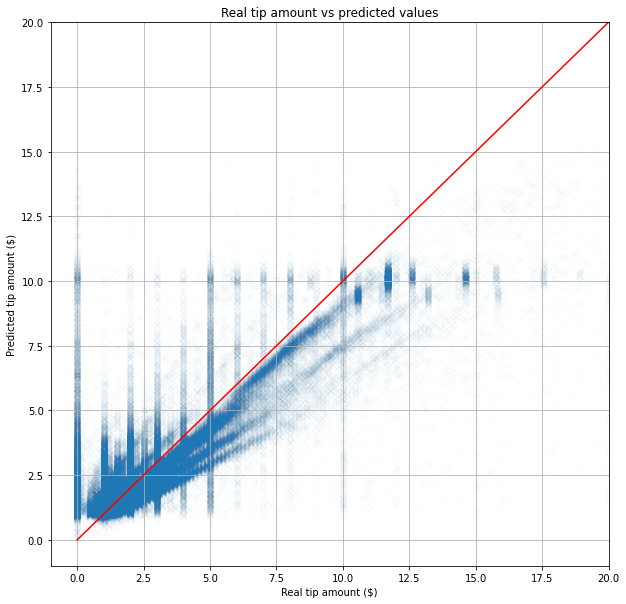

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=test_metrics_df, x='real', y='predicted', ax=ax, alpha =0.05, marker='x')
sns.lineplot(x=[0,20], y=[0,20], ax = ax, color='red')
ax.set_xlim(-1,20)
ax.set_ylim(-1,20)

ax.set_xlabel('Real tip amount ($)')
ax.set_ylabel('Predicted tip amount ($)')

ax.set_title('Real tip amount vs predicted values')
plt.grid()
mlflow.log_figure(fig,"model_error_real_vs_predicted.png")

If we analyze the trip distance / fare amount / meter engagement time against the predicted value, we can observe that the general trend is that, if these variables increase, the predicted tip amount value does as well. Moreover, we can observe that the predicted tip amount value for JFK or Newark trips is high. This is all in line with what we observed during the exploratory data analysis phase. 

Creating legend with loc="best" can be slow with large amounts of data.


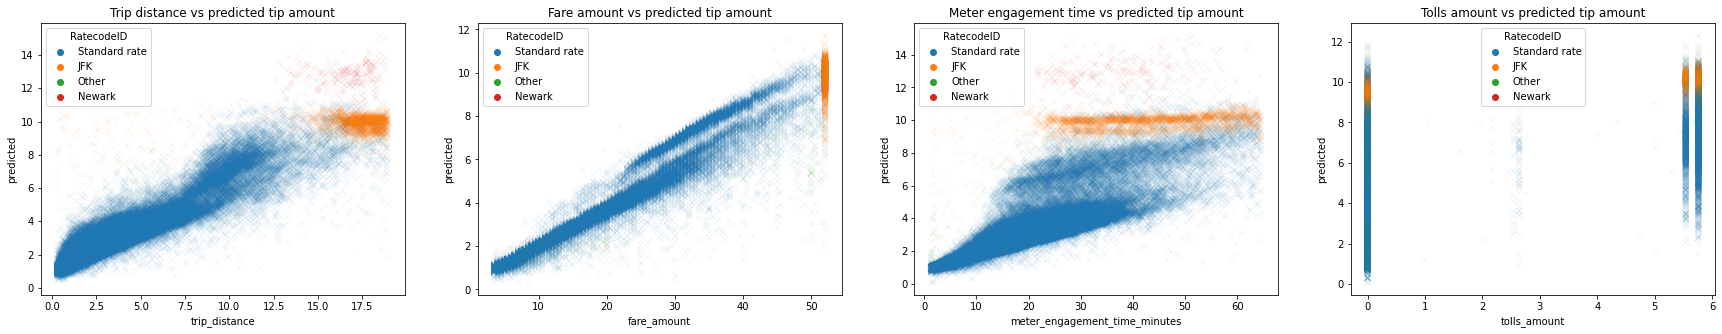

In [ ]:
fig,axs = plt.subplots(1,4, figsize=(30,5))
current_ax = 0
for col in ['trip_distance','fare_amount','meter_engagement_time_minutes', 'tolls_amount']:
  sns.scatterplot(data=test_metrics_df, x=col, y='predicted', ax=axs[current_ax], alpha =0.1, marker='x', hue = 'RatecodeID')

  if col == 'trip_distance':
    axs[current_ax].set_title('Trip distance vs predicted tip amount')
  elif col == 'fare_amount':
    axs[current_ax].set_title('Fare amount vs predicted tip amount')
  elif col == 'meter_engagement_time_minutes':
    axs[current_ax].set_title('Meter engagement time vs predicted tip amount')
  elif col == 'tolls_amount':
    axs[current_ax].set_title('Tolls amount vs predicted tip amount')

  current_ax += 1


mlflow.log_figure(fig,"predictor_variables_vs_prediction_01.png")

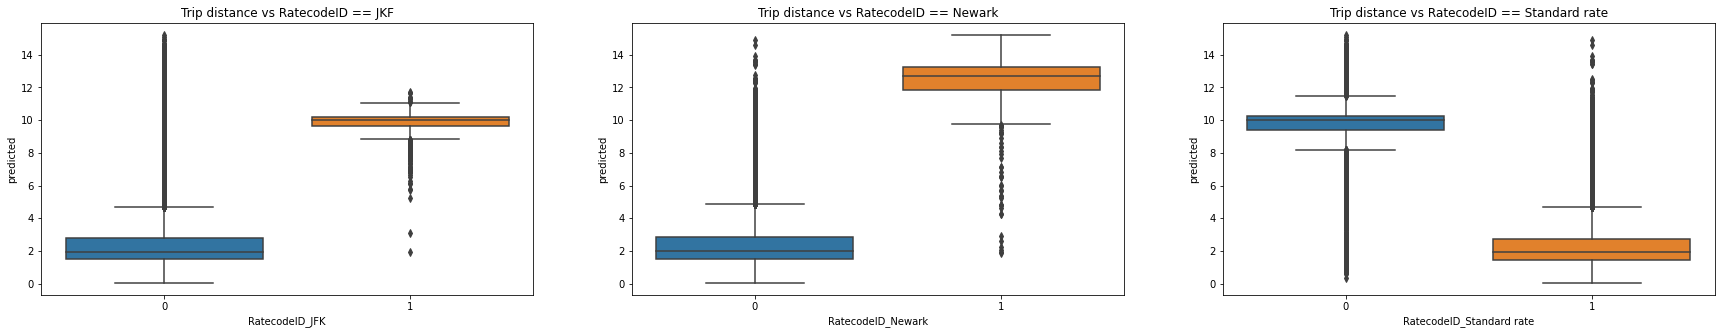

In [ ]:
fig,axs = plt.subplots(1,3, figsize=(30,5))
current_ax = 0
for col in ['RatecodeID_JFK','RatecodeID_Newark','RatecodeID_Standard rate']:
  sns.boxplot(data=test_metrics_df, x=col, y='predicted', ax=axs[current_ax])

  if col == 'RatecodeID_JFK':
    axs[current_ax].set_title('Trip distance vs RatecodeID == JKF')
  elif col == 'RatecodeID_Newark':
    axs[current_ax].set_title('Trip distance vs RatecodeID == Newark')
  elif col == 'RatecodeID_Standard rate':
    axs[current_ax].set_title('Trip distance vs RatecodeID == Standard rate')  

  current_ax += 1

mlflow.log_figure(fig,"predictor_variables_vs_prediction_02.png")

#Explainability - Importance plots

In order to understand the global behaviour of the model, we can use the importance figures available for XGBoost.

This figure represents the "weight" of the features (the number of times a feature appears in a tree). The meter engagement time is the feature which appears most in the trees.

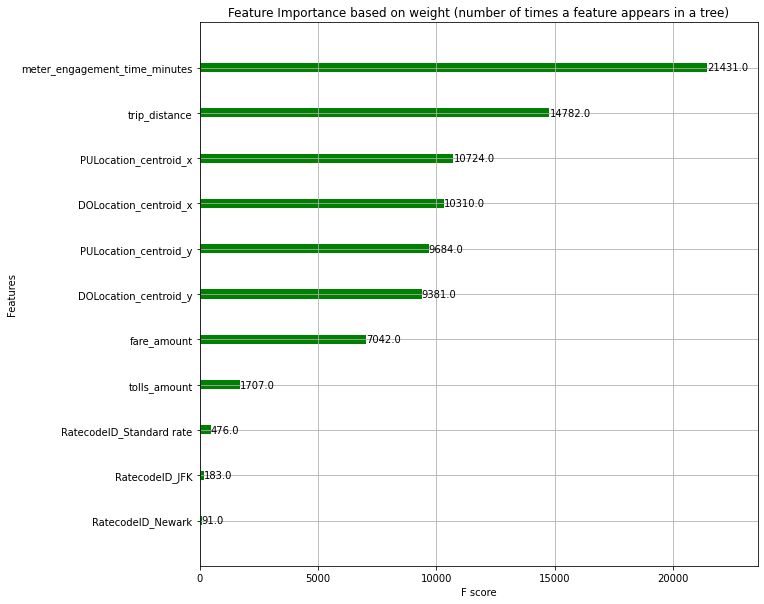

In [ ]:
plot_importance(xgb_reg, height=0.2, title = 'Feature Importance based on weight (number of times a feature appears in a tree)', color='green')
fig = plt.gcf()
fig.set_size_inches(10,10)

mlflow.log_figure(fig,"feature_importance_weight.png")

This figure represents the "avg_gain" of the features (the average gain of splits which use the feature). In this case, the fare amount is the feature which produces the highest average gain by far when it is selected to make the splits.

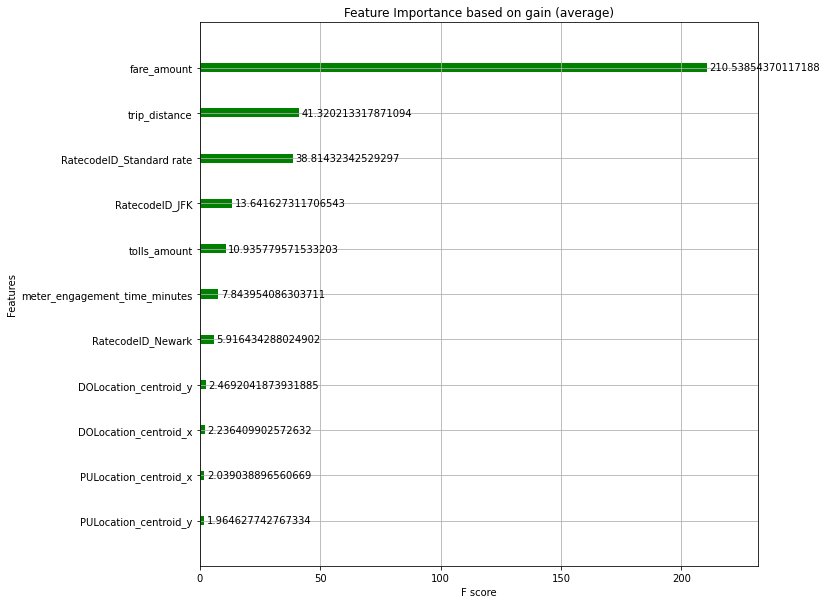

In [ ]:
plot_importance(xgb_reg, height=0.2, title = 'Feature Importance based on gain (average)', importance_type = 'gain', color='green')
fig = plt.gcf()
fig.set_size_inches(10,10)

mlflow.log_figure(fig,"feature_importance_gain_avg.png")

This figure represents the "total_gain" of the features (the total gain of splits which use the feature). In this case, the fare amount is still the feature which produces the highest total gain when it is selected to make the splits.

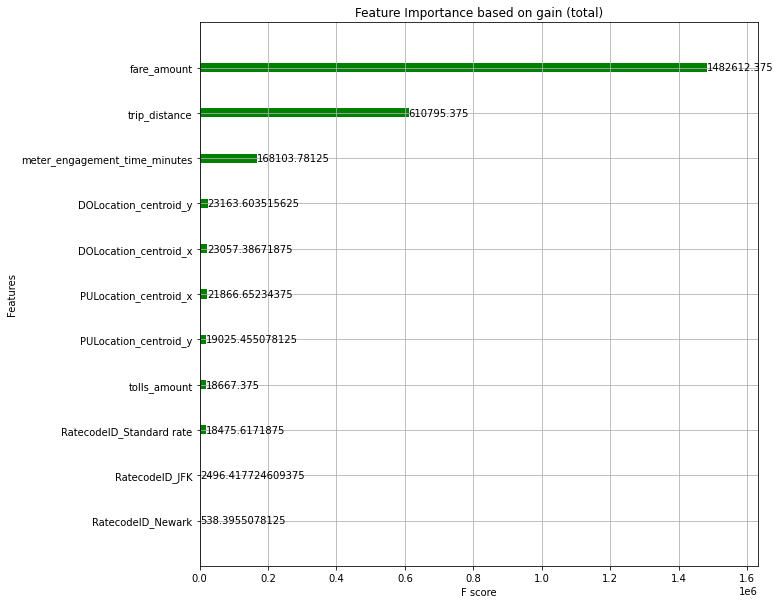

In [ ]:
plot_importance(xgb_reg, height=0.2, title = 'Feature Importance based on gain (total)', importance_type = 'total_gain', color='green')
fig = plt.gcf()
fig.set_size_inches(10,10)

mlflow.log_figure(fig,"feature_importance_gain_total.png")

This figure represents the "avg_cover" of the features (the average coverage of splits which use the feature, where coverage is defined as the number of samples affected by the split). In this case, the standard rate has a very high average coverage, which implies that it is generally used at the top nodes of the trees.

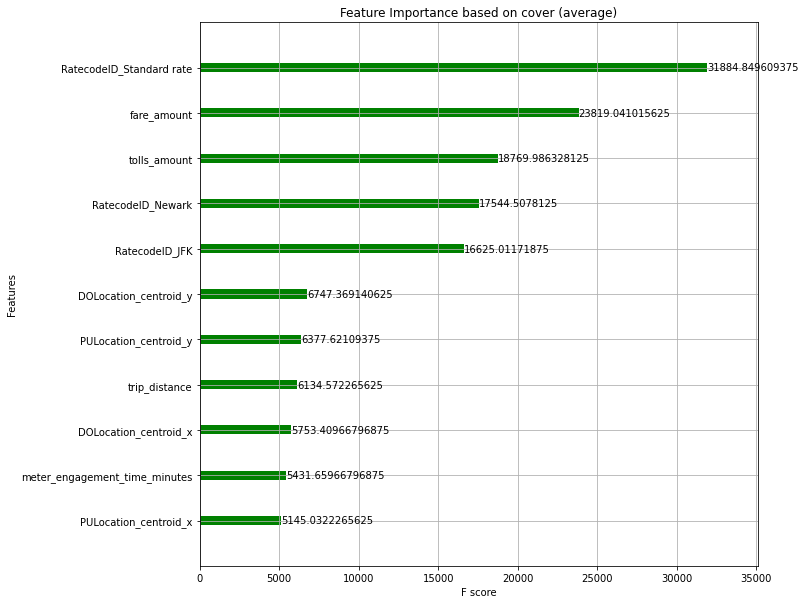

In [ ]:
plot_importance(xgb_reg, height=0.2, title = 'Feature Importance based on cover (average)', importance_type = 'cover', color='green')
fig = plt.gcf()
fig.set_size_inches(10,10)

mlflow.log_figure(fig,"feature_importance_cover_avg.png")

This figure represents the "total_cover" of the features (the total coverage of splits which use the feature, where coverage is defined as the number of samples affected by the split). In this case, the fare amount has a higher coverage than the standard rate, since it appears more times in the trees (it has a higher weight, as it can be observed in the first plot).

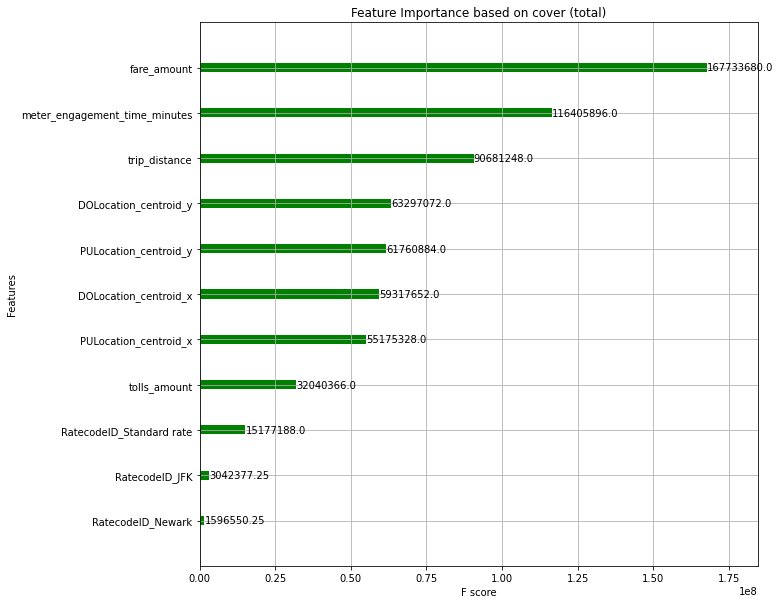

In [ ]:
plot_importance(xgb_reg, height=0.2, title = 'Feature Importance based on cover (total)', importance_type = 'total_cover', color='green')
fig = plt.gcf()
fig.set_size_inches(10,10)

mlflow.log_figure(fig,"feature_importance_cover_total.png")

#Explainability - Shapley values

One of the most popular XAI (Explainable Artificial Intelligence) methods is SHAP (SHapley Additive exPlanations), a game theoretic approach that can be used to explain the outputs of machine learning models. 

We will use 10K samples to produce the SHAP values, since this method requires a high computational power, and 10K samples are enough to understand the global behaviour of the model.

In [ ]:
X_y_test = pd.concat([X_test,y_test],axis = 1)
X_y_test_subsample = X_y_test.sample(n=10000, random_state =1)

X_test_subsample = X_y_test_subsample[X_test.columns].reset_index(drop=True)
y_test_subsample = X_y_test_subsample['tip_amount'].reset_index(drop=True)

test_subsample = xgb.DMatrix(data=X_test_subsample, label = y_test_subsample)

We create the tree explainer using the trained model, and calculate the SHAP values of the 10K samples.

In [ ]:
explainer = shap.TreeExplainer(xgb_reg)
shap_values = explainer.shap_values(X_test_subsample)

We first calculate the feature importance. The idea behind SHAP feature importance is simple: features with large absolute SHAP values are important. The result that we obtain is very similar to when we previously calculated the feature importance based on average feature gains.

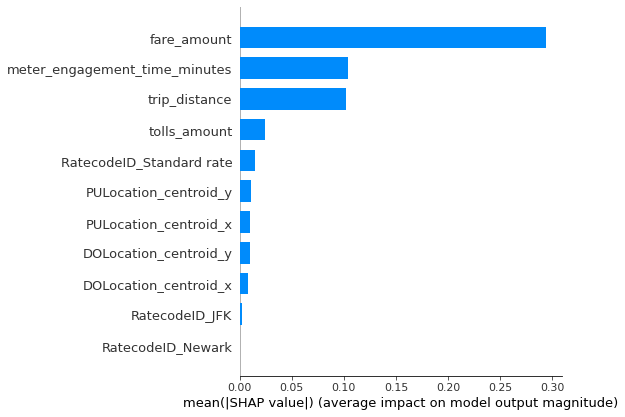

In [ ]:
fig = plt.figure(figsize=(10,10))
shap.summary_plot(shap_values,X_test_subsample,plot_type = "bar")

mlflow.log_figure(fig,"shap_feature_importance.png")

Next, we plot the SHAP summary plot. This plot combines feature importance with feature effects. Each point on the summary plot is a SHAP value for a feature and an instance. The color represents the real value of the feature from low to high. The features are ordered according to their SHAP importance.

From the plot, we can observe that larger values (red color) for fare_amount, meter_engagement_time_minutes and trip_distance, generally imply a larger, positive SHAP value. This means that these features increase the value of the final prediction when they are large, which makes sense according to the observations from our analysis.

Moreover, we can observe that, when the RatecodeID is 1 (red) for Newark and JKF, the predicted value increases. On the other hand, when it is a standard rate, it decreases. This also makes sense according to the observations from our analysis. 

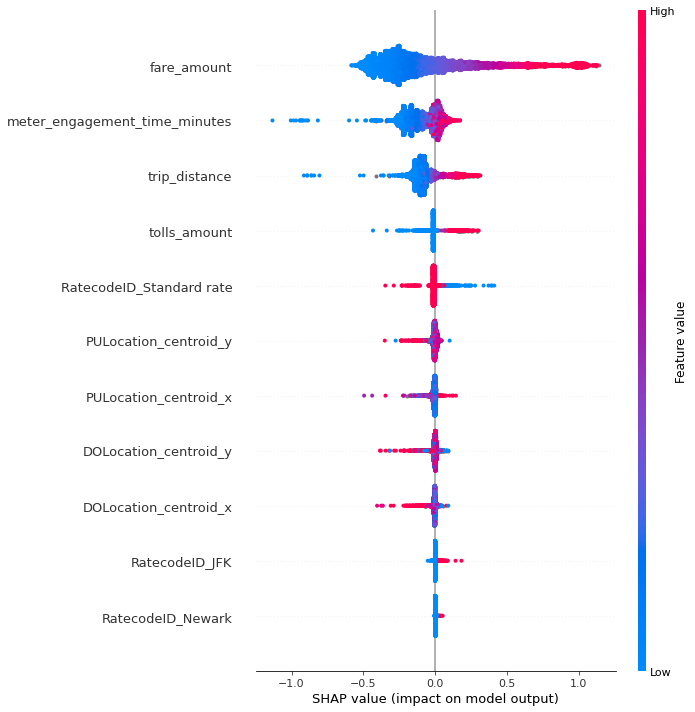

In [ ]:
fig = plt.figure(figsize=(10,10))
shap.summary_plot(shap_values,X_test_subsample,plot_size = (10,10))

mlflow.log_figure(fig,"shap_summary_plot.png")

The previous plot is useful for global model interpretability (to understand how the model behaves in general). Nevertheless, SHAP also supports local explainability, which is the ability to understand why a particular decision was made.

The figure below presents three examples of local explainability for three random predictions in the test set. They all start with the same base value (explainer.expected_value, which represents the mean prediction of the model on the train data).

It is possible to visualize, for each prediction, the feature attributions as "forces". The prediction starts from the base value. Each feature value is then a force (represented through an arrow) that pushes to either increase (positive value, red) or decrease (negative value, blue) the prediction. These forces balance each other out at the actual prediction of the data instance.

Note: the values are in a logarithmic scale.

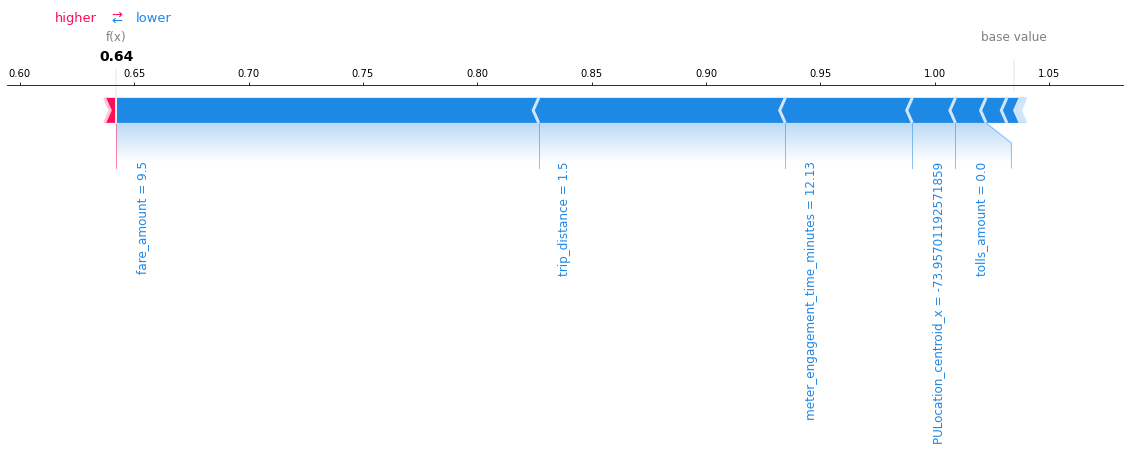

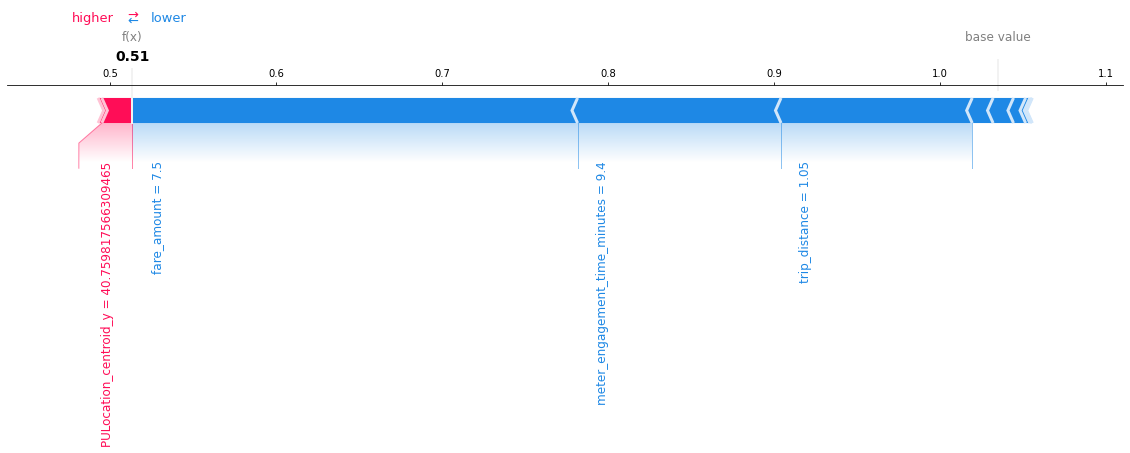

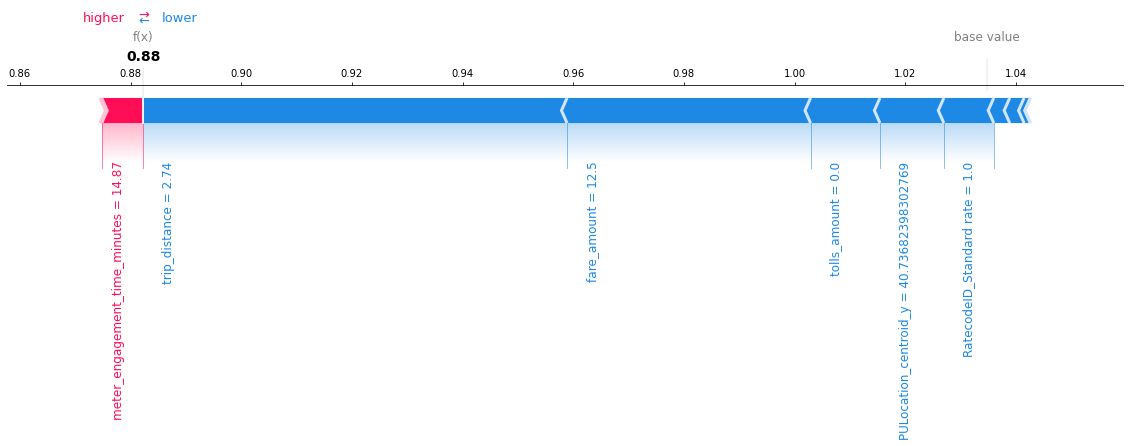

In [ ]:
def shap_plot(j):
  fig = shap.force_plot(explainer.expected_value, shap_values[j], X_test_subsample.iloc[[j]],matplotlib=True,
                        show = False, text_rotation = 90, figsize=(20,3))
  
shap_plot(0)
shap_plot(1)
shap_plot(2)

Finally, we represent the dependence plot for each feature. For each data instance, there is a point in this plot with the feature value on the x-axis and the corresponding SHAP value on the y-axis. This makes it possible to undertand how real feature values correspond to SHAP values, and it is therefore useful to comprehend how each individual variable is impacting the model behaviour.

Note: the y-axis values are in a logarithmic scale, and the limits of the y-axis for each plot can vary.

We can see the same behaviour that we had already observed in the summary plot: larger values of fare_amount, meter_engagement_time_minutes and trip_distance, generally imply a larger, positive SHAP value. Moreover, when the rate code is associated to Newark or JKF, the SHAP values are also positive.

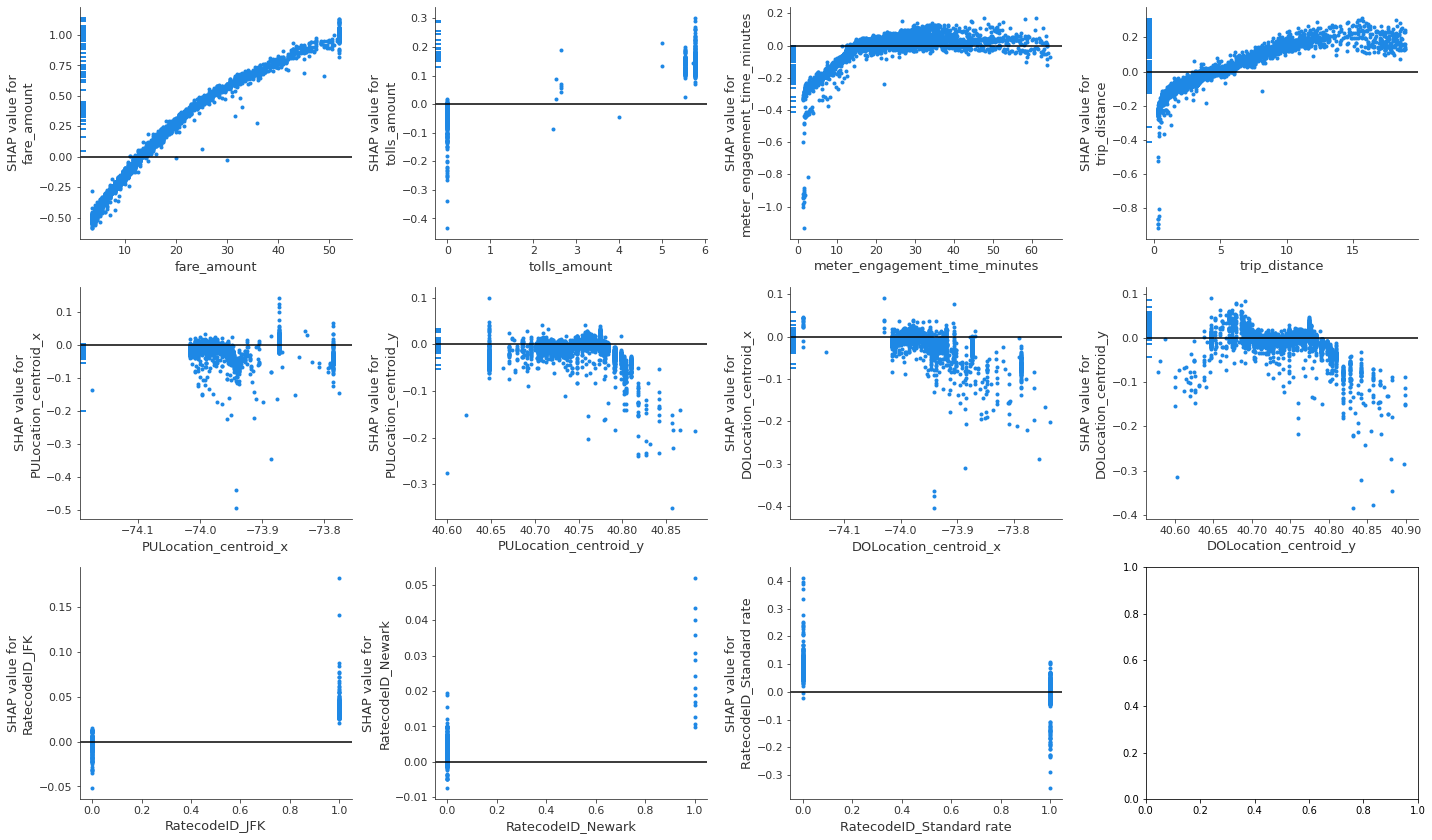

In [ ]:
fig,axs = plt.subplots(3,4, figsize=(20,12))
for index,ax in enumerate(axs.flatten()):

  if index >= len(list(X_test_subsample.columns)):
    break

  col = list(X_test_subsample.columns)[index]
  shap.dependence_plot(col, shap_values, X_test_subsample,ax=ax,show=False,interaction_index=None)
  ax.axhline(y=0,color='black')

plt.tight_layout()

mlflow.log_figure(fig,"shap_dependence_plot.png")

#MLFlow

We can access the MLFlow interactive UI through the following link. In here, we can compare the different model runs, along with the associated artifacts, figures, parameters and results.

In [ ]:
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://58ed-104-196-165-182.ngrok.io


In [ ]:
mlflow.end_run()

# Limitations

The limitations that I can think about are:

*   This model has been trained with old NYC trip data (2017), so it will probably not work as well with 2022 data. There are several factors that will have an influence on this. For example, the inflation rate of the currency or data drift problems (e.g., some extra fares might have changed due to new legislations).
*   This model has been trained with NYC data, so it might not work well for other locations.
*   We are lacking information to analyze if there is any bias in the model (e.g., due to passenger/driver gender, race, age, etc.).






# Future Work

## Future Improvements

We could try to improve this model by:
*   Training it with more recent data.
*   Scaling it to other locations apart from NYC.
*   Trying out other algorithms apart from XGBoost.
*   Supplementing the model with external datasets (e.g., U.S. Census Bureau)
*   Using grid-search with more model parameter combinations.
*   Doing a more rigorous testing (e.g., more test metrics, validating the results with business experts and with other datasets, etc.).

## How to turn this model into an API?

Once that the model is trained, we could save it into a .pickle file and deploy it in a Docker container. At inference time, we would have to reproduce all of the steps of the data pipeline (e.g., outlier cleaning, one-hot-encoding, etc.).

Most cloud providers provide solutions to easily deploy models:

*   Azure: Azure Machine Learning / ACI (Azure Container Instances) / Web Apps + API Management (for security purposes)
*   AWS: ECR (Amazon Container Registry) / AWS App Runner
*   GCP: Kubeflow / Google Data Studio

It would also be interesting to set up a MLOps infrastructure to monitor model performance and data drift in real-time. There are great open-source tools to do this (such as Evidently AI), or paid solutions (e.g., Fiddler AI). The methods that can be used at this stage depend on the type of problem (e.g., regression, classification) and whether you will have ground-truth data or not to assess model performance with production data. In this case, assuming that the real tip amount that is given to the driver is logged with a small delay after making the prediction, we could assess the model's performance using the same metrics that we used at test time (i.e., RMSE, RMSLE, MAE). We could also monitor data drift for the predictor and target variables (e.g., with Kullback–Leibler divergence) and data violations (e.g., negative fare prices).